# Ramsey model

**Table of contents**<a id='toc0_'></a>    
- 1. [Model descripton](#toc1_)    
- 2. [Solution](#toc2_)    
- 3. [Comparison with scipy solution](#toc3_)    
- 4. [Persistent technology shock](#toc4_)    
- 5. [Future persistent technology shock](#toc5_)    
- 6. [Potential analysis and extension](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

You will learn how to solve the **Ramsey model**.<br>
... also called the Ramsey-Cass-Koopman model.

In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import optimize

# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from RamseyModel import RamseyModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Model descripton](#toc0_)

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics::** Population is constant. Everybody lives forever.

**Household:** Households supply labor exogenously, $L_{t}=1$, and earns a wage $w_{t}$. The return on saving is $r_{t+1}$. Utility is 

$$
\begin{aligned}
U & =\max_{\{C_{t}\}_{t=0}^{\infty}}\sum_{t=0}^{\infty}\beta^{t}\frac{C_{t}^{1-\sigma}}{1-\sigma},\beta\in(0,1),\sigma>0\\
 & \text{s.t.}\\
 & M_{t}=(1+r_{t})N_{t-1}+w_{t}\\
 & N_{t}=M_{t}-C_{t}
\end{aligned}
$$

where $M_{t}$ is cash-on-hand and $N_{t}$ is end-of-period assets.

**Firms:** Firms rent capital $K_{t-1}$ at the rental rate $r_{t}^{K}$
and hires labor $E_{t}$ at the wage rate $w_{t}$. Firms have access
to the production function
    
$$
\begin{aligned}
Y_{t}= F(K_{t-1},E_{t})=A_t(\alpha K_{t-1}^{-\theta}+(1-\alpha)E_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1),A_t>0
\end{aligned}
$$

Profits are

$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}E_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Equilibrium:**

1. Households maximize utility
2. Firms maximize profits
3. Labor market clear: $E_{t}=L_{t}=1$
4. Goods market clear: $Y_{t}=C_{t}+I_{t}$
5. Asset market clear: $N_{t}=K_{t}$ and $r_{t}=r_{t}^{k}-\delta$
6. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

**Implication of profit maximization:** From FOCs

$$
\begin{aligned}
r_{t}^{k} & = F_{K}(K_{t-1},E_{t})=A_t \alpha K_{t-1}^{-\theta-1}Y_{t}^{-1}\\
w_{t} & = F_{E}(K_{t-1},E_{t})=A_t (1-\alpha)E_{t}^{-\theta-1}Y_{t}^{-1}
\end{aligned}
$$

**Implication of utility maximization:** From FOCs

$$
\begin{aligned}
C_{t}^{-\sigma}=\beta(1+r_{t+1})C_{t+1}^{-\sigma}
\end{aligned}
$$

**Solution algorithm:** 

We can summarize the model in the **non-linear equation system**

$$
\begin{aligned}
\boldsymbol{H}(\boldsymbol{K},\boldsymbol{C},K_{-1})=\left[\begin{array}{c}
H_{0}\\
H_{1}\\
\begin{array}{c}
\vdots\end{array}
\end{array}\right]=\left[\begin{array}{c}
0\\
0\\
\begin{array}{c}
\vdots\end{array}
\end{array}\right]
\end{aligned}
$$

where $\boldsymbol{K} = [K_0,K_1\dots]$, $\boldsymbol{C} = [C_0,C_1\dots]$, and

$$
\begin{aligned}
H_{t}
=\left[\begin{array}{c}
C_{t}^{-\sigma}-\beta(1+r_{t+1})C_{t+1}^{-\sigma}\\
K_{t}-[(1-\delta)K_{t-1}+Y_t-C_{t}]
\end{array}\right]
=\left[\begin{array}{c}
C_{t}^{-\sigma}-\beta(1+F_{K}(K_{t},1))C_{t+1}^{-\sigma}\\
K_{t}-[(1-\delta)K_{t-1} + F(K_{t-1},1)-C_{t}])
\end{array}\right]
\end{aligned}
$$

**Path:** We refer to $\boldsymbol{K}$ and $\boldsymbol{C}$ as *transition paths*.

**Implementation:** We solve this equation system in **two steps**:

1. Assume all variables are in steady  state after some **truncation horizon**.
1. Calculate the numerical **jacobian** of $\boldsymbol{H}$ wrt. $\boldsymbol{K}$
and $\boldsymbol{C}$ around the steady state
2. Solve the equation system using a **hand-written Broyden-solver**

**Note:** The equation system can also be solved directly using `scipy.optimize.root`.

**Remember:** The jacobian is just a gradient. I.e. the matrix of what the implied errors are in $\boldsymbol{H}$ when a *single* $K_t$ or $C_t$ change.

## 2. <a id='toc2_'></a>[Solution](#toc0_)

In [12]:
model = RamseyModelClass()
par = model.par
ss = model.ss
path = model.path

initializing the model:
calling .setup()
calling .allocate()


**Find steady state:** 

1. Target steady-state capital-output ratio, $K_{ss}/Y_{ss}$ of 4.0.
2. Force steady-state output $Y_{ss} = 1$.
3. Adjust $\beta$ and $A_{ss}$ to achieve this.

In [13]:
model.find_steady_state(KY_ss=4.0)

Y_ss = 1.0000
K_ss/Y_ss = 4.0000
rk_ss = 0.0750
r_ss = 0.0250
w_ss = 0.7000
A = 0.6598
beta = 0.9756


**Test that errors and the path are 0:**

In [14]:
# a. set initial value
par.K_lag_ini = ss.K

# b. set path
path.A[:] = ss.A
path.C[:] = ss.C
path.K[:] = ss.K

# c. check errors
errors_ss = model.evaluate_path_errors()
assert np.allclose(errors_ss,0.0)

In [15]:
model.calculate_jacobian()

**Solve:**

In [16]:
par.K_lag_ini = 0.50*ss.K # start away from steady state
model.solve() # find transition path

 it =   0 -> max. abs. error =   2.08774760
 it =   1 -> max. abs. error =   0.03407048
 it =   2 -> max. abs. error =   0.04084472
 it =   3 -> max. abs. error =   0.00495803
 it =   4 -> max. abs. error =   0.01354190
 it =   5 -> max. abs. error =   0.01209108
 it =   6 -> max. abs. error =   0.00397825
 it =   7 -> max. abs. error =   0.00192043
 it =   8 -> max. abs. error =   0.00097483
 it =   9 -> max. abs. error =   0.00009018
 it =  10 -> max. abs. error =   0.00010485
 it =  11 -> max. abs. error =   0.00000476
 it =  12 -> max. abs. error =   0.00000737
 it =  13 -> max. abs. error =   0.00000045
 it =  14 -> max. abs. error =   0.00000038
 it =  15 -> max. abs. error =   0.00000002
 it =  16 -> max. abs. error =   0.00000002
 it =  17 -> max. abs. error =   0.00000000


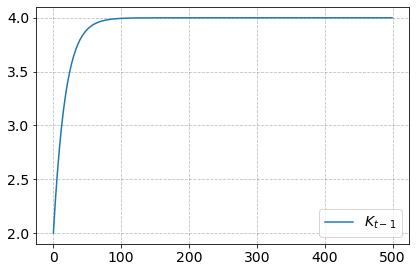

In [17]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(path.K_lag,label=r'$K_{t-1}$')
ax.legend(frameon=True)
fig.tight_layout()

## 3. <a id='toc3_'></a>[Comparison with scipy solution](#toc0_)

**Note:** scipy computes the jacobian internally

In [18]:
model_scipy = RamseyModelClass()
model_scipy.par.solver = 'scipy'
model_scipy.find_steady_state(KY_ss=4.0)
model_scipy.par.K_lag_ini = 0.50*model_scipy.ss.K
model_scipy.path.A[:] = model_scipy.ss.A
model_scipy.solve()

initializing the model:
calling .setup()
calling .allocate()
Y_ss = 1.0000
K_ss/Y_ss = 4.0000
rk_ss = 0.0750
r_ss = 0.0250
w_ss = 0.7000
A = 0.6598
beta = 0.9756


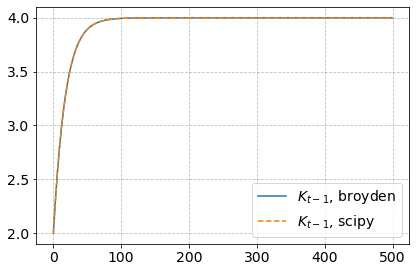

In [19]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(path.K_lag,label=r'$K_{t-1}$, broyden')
ax.plot(model_scipy.path.K_lag,ls='--',label=r'$K_{t-1}$, scipy')
ax.legend(frameon=True)
fig.tight_layout()

## 4. <a id='toc4_'></a>[Persistent technology shock](#toc0_)

**Shock:**

In [20]:
par.K_lag_ini = ss.K # start from steady state
path.A[:] = 0.95**np.arange(par.Tpath)*0.1*ss.A + ss.A # shock path

**Terminology:** This is called an MIT-shock. Households do not expect shocks. Know the full path of the shock when it arrives. Continue to believe no future shocks will happen.

**Solve:**

In [21]:
model.solve()

 it =   0 -> max. abs. error =   0.10000000
 it =   1 -> max. abs. error =   0.00096551
 it =   2 -> max. abs. error =   0.00004937
 it =   3 -> max. abs. error =   0.00000248
 it =   4 -> max. abs. error =   0.00000040
 it =   5 -> max. abs. error =   0.00000006
 it =   6 -> max. abs. error =   0.00000000


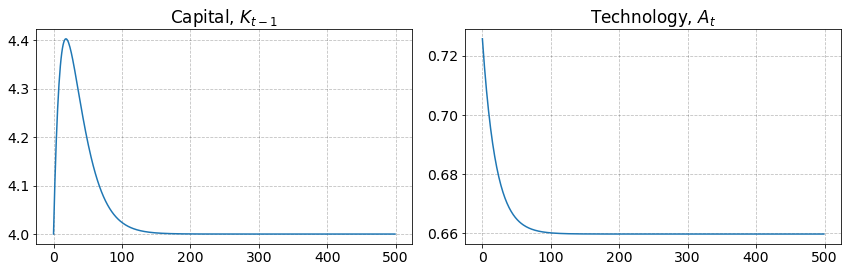

In [22]:
fig = plt.figure(figsize=(2*6,6/1.5))

ax = fig.add_subplot(1,2,1)
ax.set_title('Capital, $K_{t-1}$')
ax.plot(path.K_lag)

ax = fig.add_subplot(1,2,2)
ax.plot(path.A)
ax.set_title('Technology, $A_t$')

fig.tight_layout()

**Question:** Could a much more persistent shock be problematic?

## 5. <a id='toc5_'></a>[Future persistent technology shock](#toc0_)

**Shock happing after period $H$:**

In [23]:
par.K_lag_ini = ss.K # start from steady state

# shock
H = 50
path.A[:] = ss.A
path.A[H:] = 0.95**np.arange(par.Tpath-H)*0.1*ss.A + ss.A

**Solve:**

In [24]:
model.solve()

 it =   0 -> max. abs. error =   0.10000000
 it =   1 -> max. abs. error =   0.00267237
 it =   2 -> max. abs. error =   0.00015130
 it =   3 -> max. abs. error =   0.00000241
 it =   4 -> max. abs. error =   0.00000025
 it =   5 -> max. abs. error =   0.00000002
 it =   6 -> max. abs. error =   0.00000000


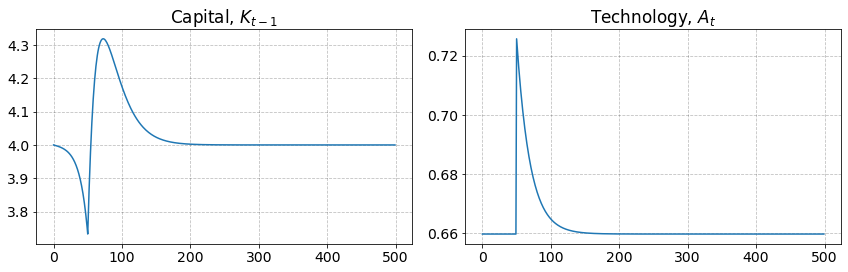

In [25]:
fig = plt.figure(figsize=(2*6,6/1.5))

ax = fig.add_subplot(1,2,1)
ax.set_title('Capital, $K_{t-1}$')
ax.plot(path.K_lag)

ax = fig.add_subplot(1,2,2)
ax.plot(path.A)
ax.set_title('Technology, $A_t$')

fig.tight_layout()

In [26]:
par.K_lag_ini = path.K[30]
path.A[:] = ss.A
model.solve()

 it =   0 -> max. abs. error =   0.05301739
 it =   1 -> max. abs. error =   0.00001569
 it =   2 -> max. abs. error =   0.00000010
 it =   3 -> max. abs. error =   0.00000000


**Take-away:** Households are forward looking and responds before the shock hits.

## 6. <a id='toc6_'></a>[Potential analysis and extension](#toc0_)

**Potential analysis:**

1. Different shocks (e.g. discount factor)
2. Multiple shocks
3. Permanent shocks ($\rightarrow$ convergence to new steady state)
4. Transition speed

**Extensions:**

1. Add a government and taxation
2. Endogenous labor supply
3. Additional assets (e.g. housing)
4. Add nominal rigidities (New Keynesian)

## Further perspectives

**The next steps beyond this course:** 

1. The **Bewley-Huggett-Aiyagari** model. A multi-period OLG model or Ramsey model with households making decisions *under uncertainty and borrowing constraints* as in lecture 11 under "dynamic optimization". Such heterogenous agent models are used in state-of-the-art research, see [Quantitative Macroeconomics with Heterogeneous Households](https://www.annualreviews.org/doi/abs/10.1146/annurev.economics.050708.142922). 

2. Further adding nominal rigidities this is called a **Heterogenous Agent New Keynesian (HANK)** model.

3. This extends the **Representative Agent New Keynesian (RANK)** model, which itself is a Ramsey model extended with nominal rigidities. 

4. The final frontier is including **aggregate risk**, which either requires linearization or using a **Krussell-Smith method**. Solving the model in *sequence-space* as we did with the Ramsey model is a frontier method (see [here](https://github.com/shade-econ/sequence-jacobian/#sequence-space-jacobian)).



